In [93]:
import pandas as pd
import numpy as np

In [94]:
#M4 cluster using Gaia's measurements of stars' locations on the sky
#3 degree x 3 degree box centered at `RA=246, dec=-26.5`
df = pd.read_csv('../data/m4_gaia_source.csv')

In [95]:
#loaing M4 cluster 
m4_df = pd.read_fwf('../data/NGC6121-1.dat', names=['source_id', 'ra', 'dec', 'phot_g_mean_mag'])

In [96]:
#classifying cluster members only
m4_sel = df['source_id'].isin(m4_df.source_id)
print(np.count_nonzero(m4_sel))

19084


In [97]:
#location right ascension and declination
params = ['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp']
X = np.array(df[params])
X.shape

(494996, 10)

In [98]:
np.count_nonzero(np.any(np.isnan(X), axis=1)) #checking for missing values

487760

In [99]:
#when we start adding more columns we might miss values
# If there _were_ missing values, we would remove them like so
nans = np.any(np.isnan(X), axis=1)
X = X[~nans]

n_classes = 10
y = m4_sel.astype(int)[~nans] 

In [100]:
from sklearn.preprocessing import StandardScaler

In [101]:
#standarizing data
transformer = StandardScaler()

X = transformer.fit_transform(X)

In [102]:
#using 50% data for testing and rest of them for training
m = X.shape[0]
test_frac = 0.5
test_sel = np.random.choice([True, False], size=m, p=[test_frac, 1-test_frac])
X_tst = X[test_sel]
X_train = X[~test_sel]

y_tst = y[test_sel]
y_train = y[~test_sel]

In [103]:
import jax
import jax.numpy as jnp

In [104]:
X_train = jnp.array(X_train)
X_tst = jnp.array(X_tst)
y_train = jnp.array(y_train)
y_tst = jnp.array(y_tst)

In [105]:
#neural network design
batch_size = 64
n_batches = X_train.shape[0] // batch_size

X_train = X_train[:n_batches * batch_size].reshape((n_batches, batch_size, *X_train.shape[1:]))
y_train = y_train[:n_batches * batch_size].reshape((n_batches, batch_size, *y_train.shape[1:]))
X_train.shape, y_train.shape

((55, 64, 10), (55, 64))

In [106]:
from flax import linen as nn

In [107]:
#model training
n_classes = 10

class DenseClassifier(nn.Module):
    """A simple dense classifier."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(n_classes)(x)
        return x

In [108]:
#summary of the model
dummy_input = jnp.ones((1, 10))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                             
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module          ┃ inputs        ┃ outputs       ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ DenseClassifier │ float32[1,10] │ float32[1,10] │                  │
├─────────┼─────────────────┼───────────────┼───────────────┼──────────────────┤
│ Dense_0 │ Dense           │ float32[1,10] │ float32[1,10] │ bias:            │
│         │                 │               │               │ float32[10]      │
│         │                 │               │               │ kernel:          │
│         │                 │               │               │ float32[10,10]   │
│         │                 │               │               │                  │
│         │                 │               │               │ 110 (440 B)      │
├─────────┼────────────────

In [109]:
X_train.shape, y_train.shape

((55, 64, 10), (55, 64))

In [110]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [111]:
#we have 330 trainable parameter
#Training

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

In [112]:
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [113]:
@jax.jit
def train_step(state, batch, label):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [114]:
@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [115]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state = create_train_state(dnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [116]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [117]:
n_epochs = 50

In [118]:
step = 0

for _ in range(n_epochs):
  for batch, label in zip(X_train, y_train):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      test_state = state
      test_state = compute_metrics(state=test_state, batch=X_tst, label=y_tst)

      for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

train epoch: 1, loss: 0.9422987699508667, accuracy: 86.36363983154297
test epoch: 1, loss: 0.2402547299861908, accuracy: 93.89848327636719
train epoch: 2, loss: 0.1925904005765915, accuracy: 94.6022720336914
test epoch: 2, loss: 0.11883120983839035, accuracy: 93.92549133300781
train epoch: 3, loss: 0.09258276969194412, accuracy: 94.63068389892578
test epoch: 3, loss: 0.05254993215203285, accuracy: 98.11015319824219
train epoch: 4, loss: 0.04789718985557556, accuracy: 97.86931610107422
test epoch: 4, loss: 0.024137552827596664, accuracy: 99.46004486083984
train epoch: 5, loss: 0.0216435007750988, accuracy: 99.40341186523438
test epoch: 5, loss: 0.01857752539217472, accuracy: 99.5140380859375
train epoch: 6, loss: 0.017568346112966537, accuracy: 99.57386016845703
test epoch: 6, loss: 0.02233380824327469, accuracy: 99.3790512084961
train epoch: 7, loss: 0.014058506116271019, accuracy: 99.57386016845703
test epoch: 7, loss: 0.015757916495203972, accuracy: 99.56803131103516
train epoch: 8, 

In [119]:
import matplotlib.pyplot as plt

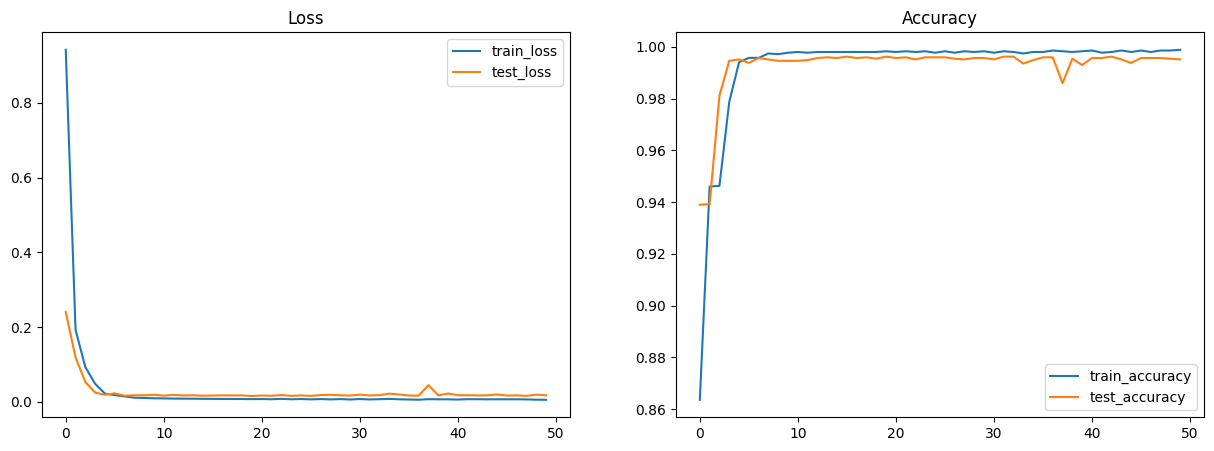

<Figure size 640x480 with 0 Axes>

In [120]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [121]:
#checking classifier
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, batch)
  return logits.argmax(axis=1)

pred = pred_step(state, X_tst)
pred

Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

(array([3470.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         234.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

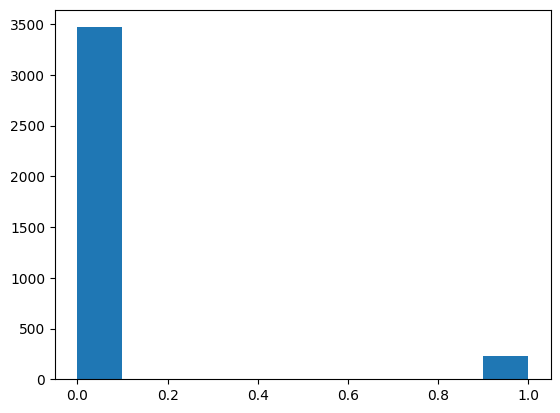

In [122]:
plt.hist(pred)

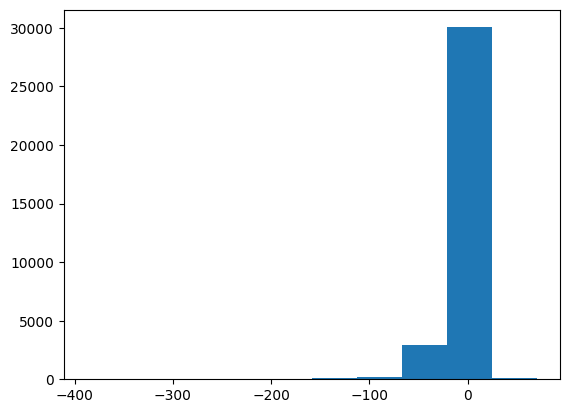

In [123]:
#difference (remember these are "log"its) of the values from the output nodes to see 
# if it's picking up hints of something useful
outputs = state.apply_fn({'params': state.params}, X_tst)
plt.hist(jnp.diff(outputs, axis=1).flatten());

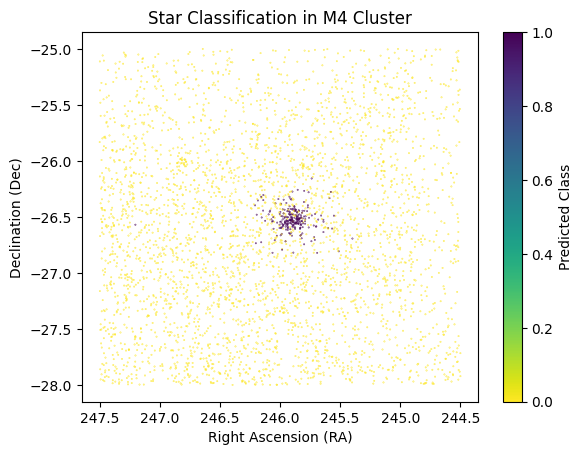

In [124]:
# Scatter plot: Right Ascension (RA) vs Declination (Dec)
plt.scatter(
    df.ra[~nans][test_sel],   # Right Ascension (x-axis)
    df.dec[~nans][test_sel],  # Declination (y-axis)
    c=jnp.argmax(outputs, axis=1),      # Color by predicted class (from classifier)
    s=0.1,                    # Size of points
    cmap='viridis_r'          # Color map for class visualization
)

plt.colorbar(label="Predicted Class")
plt.gca().invert_xaxis()
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (Dec)')
plt.title('Star Classification in M4 Cluster')
plt.show()


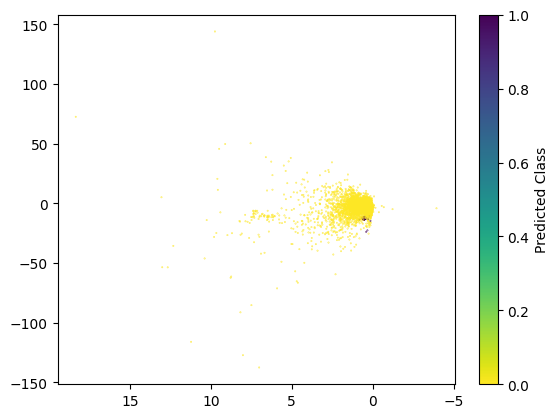

In [125]:
plt.scatter(
    df.parallax[~nans][test_sel],
    df.pmra[~nans][test_sel],  # Declination (y-axis)
    c=jnp.argmax(outputs, axis=1),      # Color by predicted class (from classifier)
    s=0.1,                    # Size of points
    cmap='viridis_r'          # Color map for class visualization
)

plt.colorbar(label="Predicted Class")
plt.gca().invert_xaxis()
plt.show()

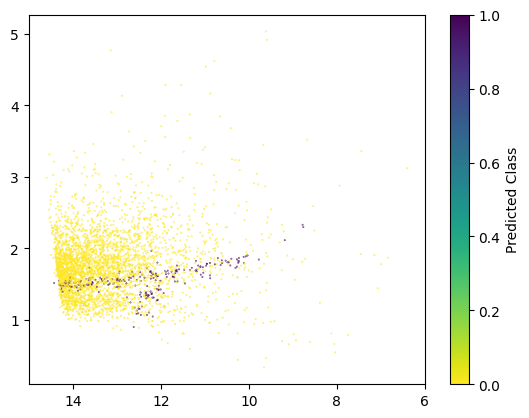

In [126]:

plt.scatter(
    df.phot_rp_mean_mag[~nans][test_sel], 
    df.bp_rp[~nans][test_sel],  # Declination (y-axis)
    c=jnp.argmax(outputs, axis=1),      # Color by predicted class (from classifier)
    s=0.1,                    # Size of points
    cmap='viridis_r'          # Color map for class visualization
)

plt.colorbar(label="Predicted Class")
plt.gca().invert_xaxis()
plt.show()


